<a href="https://www.kaggle.com/code/sharanharsoor/ctr-analysis-of-different-ml-models?scriptVersionId=122397150" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Aim of the notebook. 
In this notebook you'll observe the following points addressed. 

1. Importance of class balance in classification.
2. Models with and without feature engineering to address the importance of feature engineering.
3. Analysis of different ML models.
4. Importance of cross-validation and maintaining the history.


# Loading requiered libraries.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 0)
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format
import math
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import random
import gzip
import category_encoders as ce
pd.options.display.float_format = '{:.2f}'.format


# Reading input data and basic analysis

In [2]:
# Reading the input data

num_records = 40428967
sample_size = 5000000
skip_values = sorted(random.sample(range(1,num_records), num_records - sample_size))
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

train = pd.read_csv("../input/avazu-ctr-prediction/train.gz", parse_dates=['hour'], date_parser=parse_date,\
                     skiprows=skip_values)
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,10001264480619467364,0,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23


In [3]:
# Reading the test data.

test = pd.read_csv('../input/avazu-ctr-prediction/test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51


In [4]:
# Submission file for final score.

submission = pd.read_csv('../input/avazu-ctr-prediction/sampleSubmission.gz')
submission.head(2)

,id,click
0,10000174058809263569,0.50
1,10000182526920855428,0.50


In [5]:
# shape of the data read. 

print('Train dataset:',train.shape)
print('Test dataset:',test.shape)
print('Submission:',submission.shape)

Train dataset: (5000000, 24)
Test dataset: (4577464, 23)
Submission: (4577464, 2)


In [6]:
# hour column contains event date with all the details, extracting the same to create different columns.

train['month'] = train['hour'].dt.month
train['dayofweek'] = train['hour'].dt.dayofweek
train['day'] = train['hour'].dt.day
train['hour_time'] = train['hour'].dt.hour
train.head(2)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,1000009418151094273,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79,10,1,21,0
1,10001264480619467364,0,2014-10-21,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,f1ac7184,373ecbe6,0,0,21689,320,50,2496,3,167,100191,23,10,1,21,0


In [7]:
# checking the sum of the null values across all cloumns and rows.

train['hour'].isnull().sum().sum()

0

In [8]:
# info on each column of training dataset.

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 28 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint64        
 1   click             int64         
 2   hour              datetime64[ns]
 3   C1                int64         
 4   banner_pos        int64         
 5   site_id           object        
 6   site_domain       object        
 7   site_category     object        
 8   app_id            object        
 9   app_domain        object        
 10  app_category      object        
 11  device_id         object        
 12  device_ip         object        
 13  device_model      object        
 14  device_type       int64         
 15  device_conn_type  int64         
 16  C14               int64         
 17  C15               int64         
 18  C16               int64         
 19  C17               int64         
 20  C18               int64         
 21  C19     

In [9]:
# No null values found in the dataset.

train.isnull().sum()

id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
month               0
dayofweek           0
day                 0
hour_time           0
dtype: int64

In [10]:
# looks like following columns have outliers  C15, C16, C19, C21. 

train.describe()

,id,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
count,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00,5000000.00
mean,9221618487654660096.00,0.17,1004.97,0.29,1.02,0.33,18846.49,318.88,60.11,2113.19,1.43,227.16,53199.14,83.40,10.00,2.60,25.47,11.28
std,5326772329849109504.00,0.38,1.10,0.51,0.53,0.86,4956.68,21.28,47.35,609.06,1.33,351.07,49957.94,70.29,0.00,1.73,2.96,5.95
min,4886763614277.00,0.00,1001.00,0.00,0.00,0.00,375.00,120.00,20.00,112.00,0.00,33.00,-1.00,1.00,10.00,0.00,21.00,0.00
25%,4608003688099558912.00,0.00,1005.00,0.00,1.00,0.00,16920.00,320.00,50.00,1863.00,0.00,35.00,-1.00,23.00,10.00,1.00,23.00,7.00
50%,9221846566650479616.00,0.00,1005.00,0.00,1.00,0.00,20346.00,320.00,50.00,2323.00,2.00,39.00,100048.00,61.00,10.00,2.00,26.00,11.00
75%,13837175334198845440.00,0.00,1005.00,1.00,1.00,0.00,21894.00,320.00,50.00,2526.00,3.00,171.00,100093.00,101.00,10.00,4.00,28.00,16.00
max,18446743972517787648.00,1.00,1012.00,7.00,5.00,5.00,24049.00,1024.00,1024.00,2758.00,3.00,1959.00,100248.00,255.00,10.00,6.00,30.00,23.00


In [11]:
# Dealing with outliers by capping

col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = train[col].quantile(0.98)
    if train[col].quantile(0.98) < 0.5 * train[col].max():
        train[col][train[col] >= percentiles] = percentiles

In [12]:
# segrigating numerical and categorical variables.

numerical = []
categorical = []

for col in (train.columns):
    if train[col].dtype == "object":
        categorical.append(col)
    else:
        numerical.append(col)
print("numerical columns = ",numerical)
print("\ncategorical columns = ",categorical)

numerical columns =  ['id', 'click', 'hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour_time']

categorical columns =  ['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model']


0   0.83
1   0.17
Name: click, dtype: float64




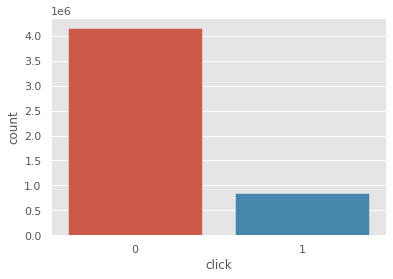

In [13]:
# y is the target variable, analysing the same.
# 83% values are 0 and 17% values are 1. data is highly imbalance. 

print(train.click.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x='click', data=train)
plt.show()

# Analysing categorical variables.

In [14]:
print("unique counts of site_id", len(train['site_id'].unique()))
print("----------------------")
print(train['site_id'].value_counts(normalize = True))

unique counts of site_id 3542
----------------------
85f751fd   0.36
1fbe01fe   0.16
e151e245   0.07
d9750ee7   0.02
5b08c53b   0.02
           ... 
cdd1bacc   0.00
2b4d5c50   0.00
a09ce10c   0.00
33061721   0.00
e0fbf47c   0.00
Name: site_id, Length: 3542, dtype: float64


In [15]:
print("unique counts of site_domain", len(train['site_domain'].unique()))
print("----------------------")
print(train['site_domain'].value_counts(normalize = True))

unique counts of site_domain 4516
----------------------
c4e18dd6   0.37
f3845767   0.16
7e091613   0.08
7687a86e   0.03
98572c79   0.02
           ... 
5978e75e   0.00
efb2f861   0.00
3d64f1ed   0.00
ed0bf30b   0.00
e05edb43   0.00
Name: site_domain, Length: 4516, dtype: float64


In [16]:
print("unique counts of site_category", len(train['site_category'].unique()))
print("----------------------")
print(train['site_category'].value_counts(normalize = True))

unique counts of site_category 25
----------------------
50e219e0   0.41
f028772b   0.31
28905ebd   0.18
3e814130   0.08
f66779e6   0.01
75fa27f6   0.00
335d28a8   0.00
76b2941d   0.00
c0dd3be3   0.00
72722551   0.00
dedf689d   0.00
70fb0e29   0.00
0569f928   0.00
8fd0aea4   0.00
a818d37a   0.00
42a36e14   0.00
e787de0e   0.00
bcf865d9   0.00
5378d028   0.00
9ccfa2ea   0.00
da34532e   0.00
c706e647   0.00
110ab22d   0.00
74073276   0.00
a72a0145   0.00
Name: site_category, dtype: float64


In [17]:
print("unique counts of app_id", len(train['app_id'].unique()))
print("----------------------")
print(train['app_id'].value_counts(normalize = True))

unique counts of app_id 5204
----------------------
ecad2386   0.64
92f5800b   0.04
e2fcccd2   0.03
febd1138   0.02
9c13b419   0.02
           ... 
7357f2f2   0.00
008e6bde   0.00
1ec51104   0.00
bb8052e1   0.00
d1fcd541   0.00
Name: app_id, Length: 5204, dtype: float64


In [18]:
print("unique counts of app_domain", len(train['app_domain'].unique()))
print("----------------------")
print(train['app_domain'].value_counts(normalize = True))

unique counts of app_domain 327
----------------------
7801e8d9   0.67
2347f47a   0.13
ae637522   0.05
5c5a694b   0.03
82e27996   0.02
           ... 
86aa8fec   0.00
4890a39e   0.00
c15f229b   0.00
96c7bad2   0.00
cea55998   0.00
Name: app_domain, Length: 327, dtype: float64


In [19]:
print("unique counts of app_category", len(train['app_category'].unique()))
print("----------------------")
print(train['app_category'].value_counts(normalize = True))

unique counts of app_category 30
----------------------
07d7df22   0.65
0f2161f8   0.24
cef3e649   0.04
8ded1f7a   0.04
f95efa07   0.03
d1327cf5   0.00
09481d60   0.00
dc97ec06   0.00
75d80bbe   0.00
fc6fa53d   0.00
4ce2e9fc   0.00
879c24eb   0.00
a3c42688   0.00
4681bb9d   0.00
0f9a328c   0.00
a86a3e89   0.00
2281a340   0.00
8df2e842   0.00
79f0b860   0.00
a7fd01ec   0.00
0bfbc358   0.00
2fc4f2aa   0.00
18b1e0be   0.00
7113d72a   0.00
5326cf99   0.00
bf8ac856   0.00
bd41f328   0.00
0d82db25   0.00
71af18ce   0.00
4b7ade46   0.00
Name: app_category, dtype: float64


In [20]:
print("unique counts of device_id", len(train['device_id'].unique()))
print("----------------------")
print(train['device_id'].value_counts(normalize = True))

unique counts of device_id 599455
----------------------
a99f214a   0.83
0f7c61dc   0.00
c357dbff   0.00
936e92fb   0.00
afeffc18   0.00
           ... 
f517d7b9   0.00
3550c7b3   0.00
e0d2d0bd   0.00
dd79905c   0.00
8417ac18   0.00
Name: device_id, Length: 599455, dtype: float64


In [21]:
print("unique counts of device_ip", len(train['device_ip'].unique()))
print("----------------------")
print(train['device_ip'].value_counts(normalize = True))

unique counts of device_ip 1903995
----------------------
6b9769f2   0.01
431b3174   0.00
2f323f36   0.00
af9205f9   0.00
930ec31d   0.00
           ... 
3ab3b67e   0.00
97488137   0.00
cb35517b   0.00
75f01808   0.00
e352da7d   0.00
Name: device_ip, Length: 1903995, dtype: float64


In [22]:
print("unique counts of device_model", len(train['device_model'].unique()))
print("----------------------")
print(train['device_model'].value_counts(normalize = True))

unique counts of device_model 6555
----------------------
8a4875bd   0.06
1f0bc64f   0.04
d787e91b   0.03
76dc4769   0.02
be6db1d7   0.02
           ... 
f5486ff8   0.00
b22cf01e   0.00
d2f5751a   0.00
0c470da9   0.00
19ba748a   0.00
Name: device_model, Length: 6555, dtype: float64


## observations :
1. All categorical variables have lot of unique values in it, one hot encoding is not a scalable approach. 
2. we will go with label encoding and scaling approach is a better idea for this.

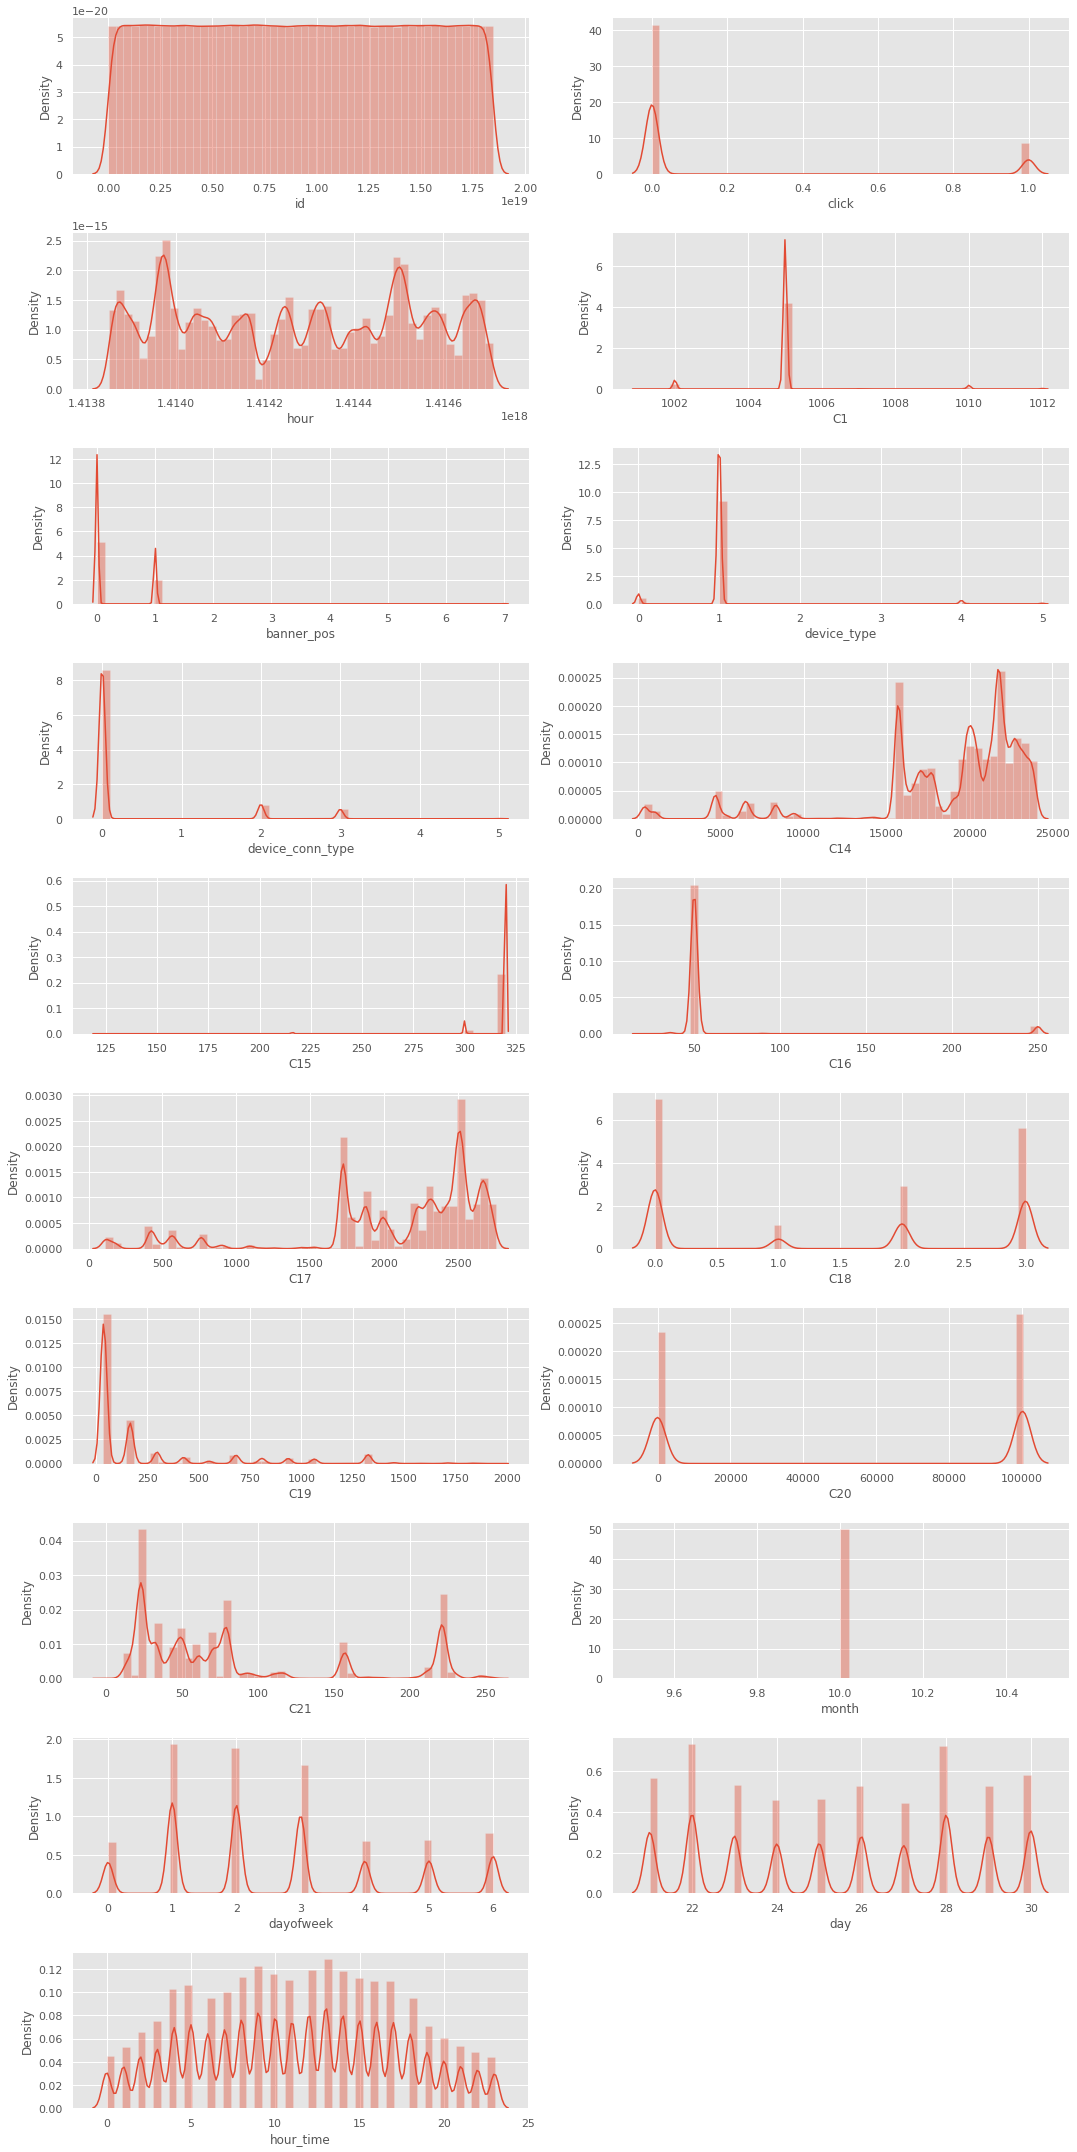

In [23]:
# The code below will plot histograms for all numerical columns 

n = 2
plt.figure(figsize=[15,3*math.ceil(len(numerical)/n)])

for i in range(len(numerical)):
    plt.subplot(math.ceil(len(numerical)/n),n,i+1)
    sns.distplot(train[numerical[i]])

plt.tight_layout()
plt.show()

## observations 
1. Y and Click looks like same columns, after co-relation we can drop on of them.
2. month column has only 1 data entry, no exrtra information is added, can be dropped 
3. banner pos, device conn, C20, C15, C16 looks like data is cenetered around certain values. 


In [24]:
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'month', 'dayofweek',
       'day', 'hour_time'],
      dtype='object')

Text(0.5, 1.05, 'Pearson correlation of Features')

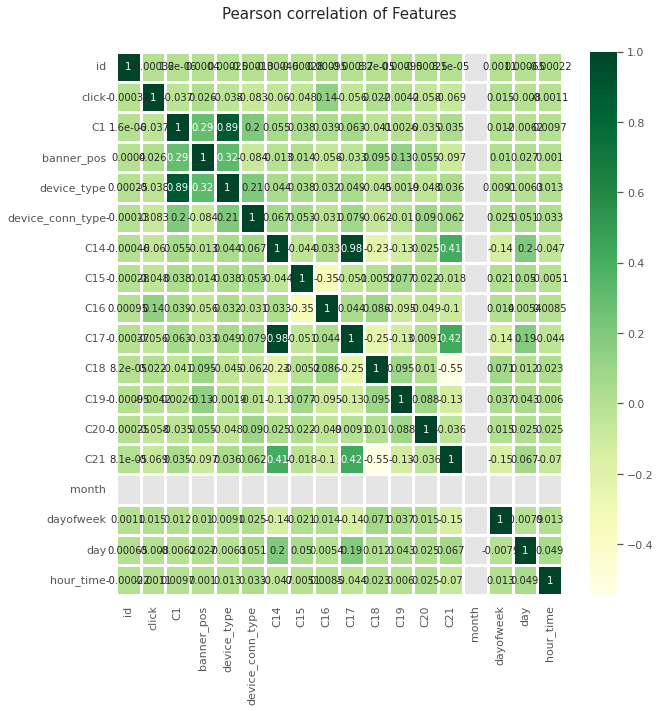

In [25]:
# Pearson correlation table to find the relationship with output with all input features. 

corr = train.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)

## observation
1. month has got no significance, better to drop it
2. y and click are same drop click column 
3. C14 and C17 are highly co-related, later will remove one of them after the base model.
4. device type with C1 are highly co-related, later will remove one of them after the base model.
5. Removing C20 anomalised column, since it have got nearly 47% of values with -1. As a categorical variable
it's not expected to have values as -1.

In [26]:
# as said above dropping columns. 

train.drop(['month', 'C20'], axis=1, inplace=True)
train.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day',
       'hour_time'],
      dtype='object')

# Data preperation


In [27]:
# id column have a unique columns so, keeping that don't proive any significance,hence dropping.
# hour column have been derived into different columns, hence dropping. 
# rename click to y (output)
# after dropping hour column, hour_time can be made as hour

train.drop(['id', 'hour'], axis = 1, inplace = True) 
train.rename(columns={'click': 'y',
                   'hour_time': 'hour'},
          inplace=True, errors='raise')

train.columns

Index(['y', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category',
       'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip',
       'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C21', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [28]:
# dataset is huge and running multiple algo will take time and resources might exhaust, 
# hence taking only 10% of the data for analysis.

sampled_data = train.sample(frac=0.1, random_state=42)
X = sampled_data.drop(['y'], axis=1)
y = sampled_data['y']

0   0.83
1   0.17
Name: y, dtype: float64




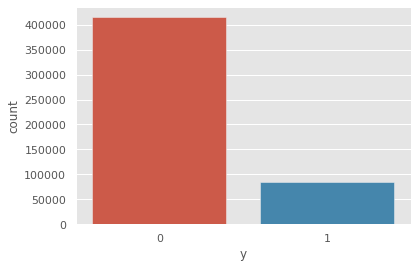

In [29]:
# After taking the sample of data, still the ratio of output remains same.

print(train.y.value_counts(normalize = True))
print("\n")
plt.figure()
sns.countplot(x=y)
plt.show()

In [30]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,1005,1,0.13,0.13,0.18,0.20,0.20,0.20,0.17,0.17,0.14,1,0,22681,320,50,2528,0,39,221,1,28,10
4993932,1005,0,0.12,0.12,0.13,0.30,0.14,0.25,0.17,0.17,0.01,1,2,23161,320,50,2667,0,47,221,3,30,23


In [31]:
'''
target_encoder = ce.TargetEncoder()
for col in (X.columns):
    if X[col].dtype == "object":
        X[col] = target_encoder.fit_transform(X[col], y)

X.head(2)
'''

'\ntarget_encoder = ce.TargetEncoder()\nfor col in (X.columns):\n    if X[col].dtype == "object":\n        X[col] = target_encoder.fit_transform(X[col], y)\n\nX.head(2)\n'

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)

# Building basic models [no feature engineering]
 1. in this no feature engineering is done apart from removing definate columns click and month.
 2. We will run 3 models 
      a. Logistic regression [for explainability and finding linear relationship]
      b. Decision tree classifier [for explainability and also for non-linear relation]
      c. Random forest classifier [for accuracy and improving the model] 
 3. Target variable is highly imbalance, so model will be baised towards majority class. for every base model will try with both balance and imbalance data.

## defining functions for later use.

In [33]:
# this function helps in evaluation the given model and provide accuracy and confusion matrix. 

def model_eval(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    #print(accuracy)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    #print(cnf_matrix)
    #metrics.plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    return accuracy, cnf_matrix

In [34]:
# Plots the ROC curve and returns false positive rate, true positive rate, and thresholds. 

def draw_roc(model, Xtest, actual):
    probs = model.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

In [35]:
# Returns the ctossvalidation score for given number of n folds. 

def cross_val (model, x, y, folds):
    crossvalidation = cross_val_score(model, x, y, cv= folds, n_jobs=-1)
    return crossvalidation

In [36]:
# this stores the results in dataframe for evaluating the final result. 

def store_results(name, ytrain, xtrain, ytest, xtest, model, folds):
    
    crossvalidation = cross_val(model, xtrain, ytrain, folds)
    
    accuracy_test, cm1 =  model_eval(model, xtrain, ytrain)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_test = TP / (TP+FP)
    precision_test = TP / (TP+FN)
    
    accuracy_train, cm1 =  model_eval(model, xtest, ytest)
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    recall_train = TP / (TP+FP)
    precision_train = TP / (TP+FN)

    entry = {'Model': [name],
          'Accuracy_train': [accuracy_train],
          'recall_train': [recall_train],
          'precision_train': [precision_train],
          'Accuracy_test': [accuracy_train],
          'recall_test': [recall_train],
          'precision_test': [precision_train],
          'CrossVal_Mean': [crossvalidation.mean()],           
          'CrossVal1': [crossvalidation[0]],
          'CrossVal2': [crossvalidation[1]],
          'CrossVal3': [crossvalidation[2]],
          'CrossVal4': [crossvalidation[3]],
          'CrossVal5': [crossvalidation[4]],
          }
    result = pd.DataFrame(entry)
    return result

## Dummy classifier for verification
Dummy classifier helps in baseling the model performace w.r.t dominanat class. 

In [37]:
outcome = pd.DataFrame()
dummy_clf = DummyClassifier(strategy= "most_frequent")
dummy_clf.fit(X_train, y_train)
accuracy, cnf_matrix  = model_eval(dummy_clf, X_train, y_train)
print(accuracy)
print(cnf_matrix)
temp = store_results("Dummy classifier", y_train, X_train, y_test, X_test, dummy_clf, 5)
outcome = outcome.append(temp)
outcome

0.8297828571428572
[[290424      0]
 [ 59576      0]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83


## Basic regression model with imbalance precidtor 

In [38]:
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
1600864,1005,1,0.12,0.12,0.13,0.00,0.20,0.11,0.17,0.15,0.07,1,0,20744,320,50,2394,0,175,116,3,23,20
3018132,1005,1,0.08,0.08,0.18,0.20,0.20,0.20,0.17,0.17,0.15,1,0,19771,320,50,2227,0,935,48,0,27,5
3392943,1010,1,0.12,0.12,0.13,0.04,0.20,0.11,0.17,0.17,0.05,4,2,22920,320,50,2649,0,39,204,1,28,2
2833272,1002,0,0.21,0.24,0.13,0.20,0.20,0.20,0.17,0.25,0.05,0,0,21789,320,50,2512,2,291,52,6,26,16
2714178,1002,0,0.15,0.12,0.13,0.20,0.20,0.20,0.17,0.17,0.19,0,0,19665,320,50,2253,2,303,52,6,26,11


In [39]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
1600864,0.36,0.14,0.12,0.12,0.25,0.00,0.30,0.18,0.18,0.15,0.07,0.20,0.00,0.86,1.00,0.13,0.86,0.00,0.08,0.45,0.50,0.22,0.87
3018132,0.36,0.14,0.08,0.08,0.34,0.20,0.30,0.33,0.18,0.17,0.16,0.20,0.00,0.82,1.00,0.13,0.80,0.00,0.50,0.19,0.00,0.67,0.22
3392943,0.82,0.14,0.12,0.12,0.25,0.04,0.30,0.18,0.18,0.17,0.05,0.80,0.40,0.95,1.00,0.13,0.96,0.00,0.00,0.80,0.17,0.78,0.09
2833272,0.09,0.00,0.22,0.24,0.25,0.20,0.30,0.33,0.18,0.25,0.05,0.00,0.00,0.90,1.00,0.13,0.91,0.67,0.14,0.20,1.00,0.56,0.70
2714178,0.09,0.00,0.15,0.12,0.25,0.20,0.30,0.33,0.18,0.17,0.19,0.00,0.00,0.81,1.00,0.13,0.81,0.67,0.15,0.20,1.00,0.56,0.48


In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [41]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
4201388,0.36,0.14,0.07,0.07,0.34,0.20,0.30,0.33,0.18,0.17,0.39,0.20,0.00,0.82,1.00,0.13,0.80,0.00,0.50,0.19,0.33,0.89,0.39
2922442,0.36,0.00,0.50,0.50,0.40,0.20,0.30,0.33,0.18,0.17,0.23,0.20,0.00,0.84,0.90,1.00,0.84,0.67,0.00,0.09,1.00,0.56,0.91


In [42]:
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - imbalance predict", y_train, X_train, y_test, X_test, model, 5)
outcome = outcome.append(temp)
outcome

0.8440933333333334
[[121085   3382]
 [ 20004   5529]]


,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85


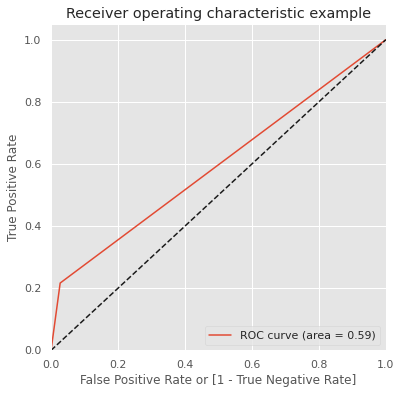

(array([0.        , 0.02717186, 1.        ]),
 array([0.       , 0.2165433, 1.       ]),
 array([2, 1, 0]))

In [43]:
draw_roc(model, X_test, y_test)

### Observation
1. Logistic regression is behaving almost same as dummy classifier.
2. ROC_AUC isn't doing better at all

## Basic regression model with balance precidtor 

Original dataset shape  Counter({0: 414891, 1: 85109})
Resampled dataset shape Counter({0: 414891, 1: 414891})


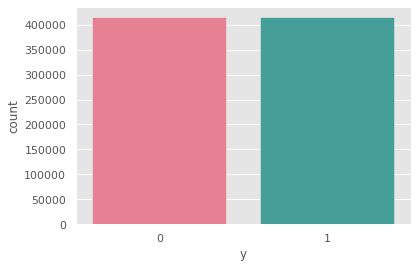

In [44]:
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [45]:
x_new.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,1005,1,0.13,0.13,0.18,0.20,0.20,0.20,0.17,0.17,0.14,1,0,22681,320,50,2528,0,39,221,1,28,10
1,1005,0,0.12,0.12,0.13,0.30,0.14,0.25,0.17,0.17,0.01,1,2,23161,320,50,2667,0,47,221,3,30,23


In [46]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

In [47]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,0.36,0.00,0.16,0.16,0.34,0.20,0.30,0.33,0.18,0.11,0.10,0.20,0.00,0.92,1.00,0.13,0.93,1.00,0.01,0.16,0.00,0.67,0.52
190121,0.36,0.00,0.12,0.12,0.25,0.02,0.04,0.18,0.18,0.00,0.02,0.20,0.60,0.88,1.00,0.13,0.87,0.33,0.07,0.28,0.00,0.67,0.96


In [48]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

0.7226504910920521
[[89979 34489]
 [34553 89914]]


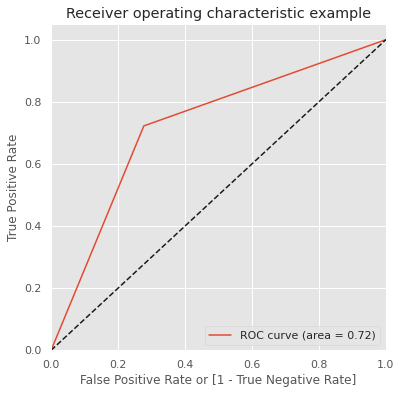

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72


In [49]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
y_pred = model.predict(X_test)
accuracy, cnf_matrix = model_eval(model, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("logistic regres - balance predict", y_train, X_train, y_test, X_test, model, 5)
draw_roc(model, X_test, y_test)
outcome = outcome.append(temp)
outcome

##  Decision tree classifier with unbalanced data 

In [50]:
# decision tree doesn't require feature scaling, will use the raw features directly 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
1600864,1005,1,0.12,0.12,0.13,0.00,0.20,0.11,0.17,0.15,0.07,1,0,20744,320,50,2394,0,175,116,3,23,20
3018132,1005,1,0.08,0.08,0.18,0.20,0.20,0.20,0.17,0.17,0.15,1,0,19771,320,50,2227,0,935,48,0,27,5


0.7767266666666667
[[107524  16943]
 [ 16548   8985]]


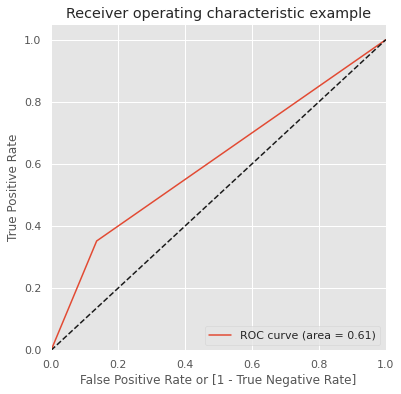

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78


In [51]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("decision tree basic - imbalance predict", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = outcome.append(temp)
outcome


##  Decision tree classifier with balanced data 


In [52]:
# x_new and y_new are already calculated before for balanced dataset using the same.

X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,1005,0,0.16,0.16,0.18,0.20,0.20,0.20,0.17,0.11,0.09,1,0,22267,320,50,2566,3,47,42,0,27,12
190121,1005,0,0.12,0.12,0.13,0.02,0.02,0.11,0.17,0.00,0.02,1,3,21189,320,50,2424,1,161,71,0,27,22


0.8956434410589109
[[102285  22183]
 [  3795 120672]]


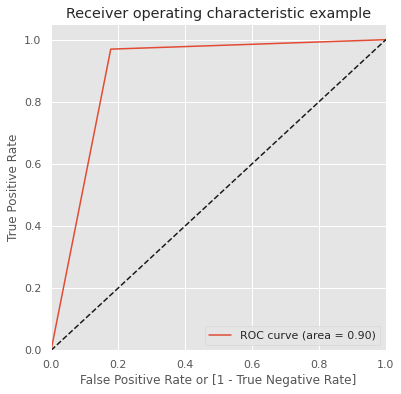

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
0,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88


In [53]:
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)
y_preds = dt_basic.predict(X_test)
accuracy, cnf_matrix = model_eval(dt_basic, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("decision tree basic - balance predict", y_train, X_train, y_test, X_test, dt_basic, 5)
draw_roc(dt_basic, X_test, y_test)
outcome = outcome.append(temp)
outcome

### observation 
1. decision tree on unbalanced data isn't doing that great.
1. decision tree on balanced data is really doing very good. 
2. decision tree on balanced data on test data as well as cross validation is doing really well.
4. ROC_AUC curve looks really good.

## Random forest classifier with imbalanced data 


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
1600864,1005,1,0.12,0.12,0.13,0.00,0.20,0.11,0.17,0.15,0.07,1,0,20744,320,50,2394,0,175,116,3,23,20
3018132,1005,1,0.08,0.08,0.18,0.20,0.20,0.20,0.17,0.17,0.15,1,0,19771,320,50,2227,0,935,48,0,27,5


0.82308
[[116551   7916]
 [ 18622   6911]]


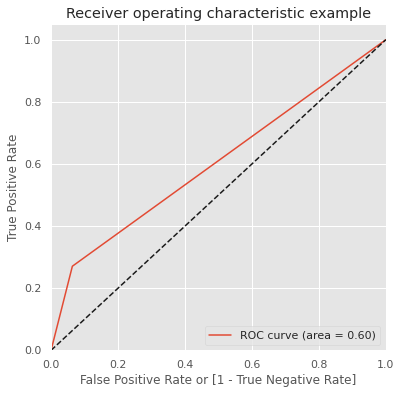

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
0,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.82,0.83,0.83,0.82,0.83


In [55]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - imbalance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = outcome.append(temp)
outcome


## Random forest classifier with balanced data 


In [56]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,1005,0,0.16,0.16,0.18,0.20,0.20,0.20,0.17,0.11,0.09,1,0,22267,320,50,2566,3,47,42,0,27,12
190121,1005,0,0.12,0.12,0.13,0.02,0.02,0.11,0.17,0.00,0.02,1,3,21189,320,50,2424,1,161,71,0,27,22


0.906758792455862
[[104466  20002]
 [  3209 121258]]


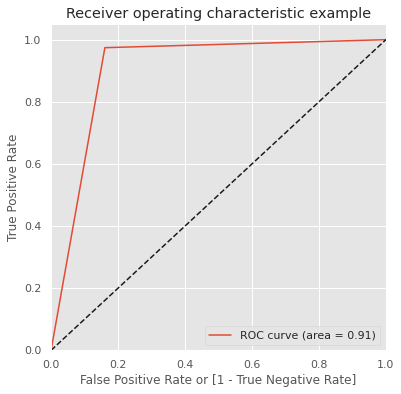

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
0,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.82,0.83,0.83,0.82,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89


In [57]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_preds = model_rf.predict(X_test)
accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print(accuracy)
print(cnf_matrix)
temp = store_results("Random forest basic - balance predict", y_train, X_train, y_test, X_test, model_rf, 5)
draw_roc(model_rf, X_test, y_test)
outcome = outcome.append(temp)
outcome

### observarion :
 1. Random forest data with imbalance data is over fitted for training data.
 1. Random forest with balanced data set is performing the best so far on both train and test data.
 2. Random forest with balanced data holding good for cross validation as well.
 Conclusion based on simple models built  :- Random forest on balanced data set is the best model built


# Building basic models [with feature engineering]
 in this will follow on building same models as before.
 1. Logistic regression.
 2. Decision tree classifier.
 3. Random forest Classifier.
 One Important observation : While building, we observed that building with balanced predictor is a better apporach. hence all the 3 models in feature engineering case will be built using balanced data set only. 

In [58]:
data_feature = sampled_data.copy()

Text(0.5, 1.05, 'Pearson correlation of Features')

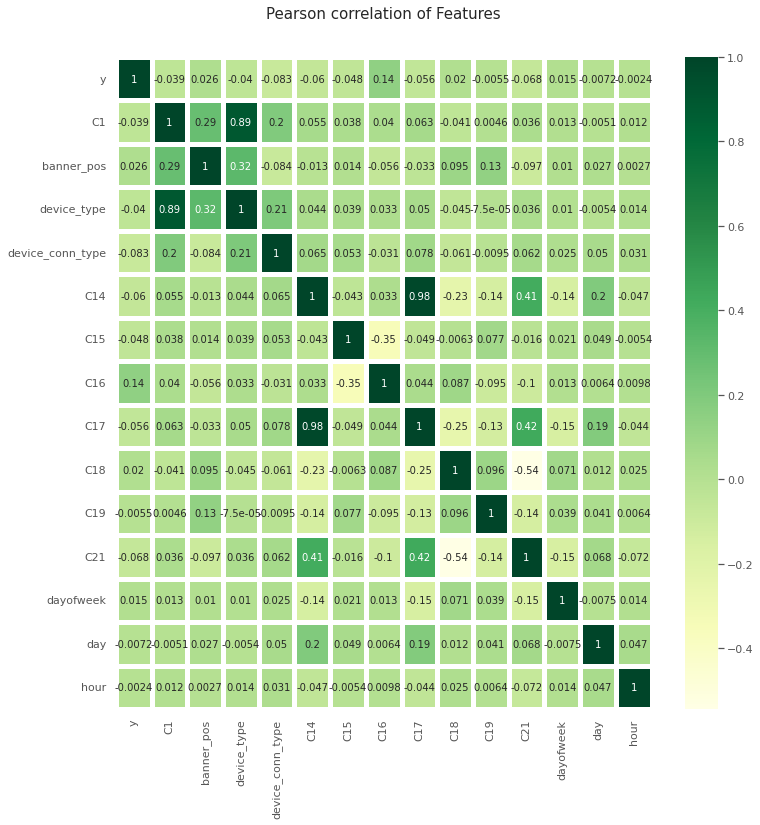

In [59]:
corr = data_feature.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr, ax=ax, annot=True, linewidths=5,cmap='YlGn')
plt.title("Pearson correlation of Features", y=1.05, size=15)


In [60]:
# C1 and device_type are highly corelated, since C1 is anomalised column we can drop it.
# C14 and C17 are highly co-related, dropping either is a good idea.

data_feature.drop(['C14', 'C1'], axis=1, inplace= True)

In [61]:
X = data_feature.drop(['y'], axis=1)
y = data_feature['y']

In [62]:
target_encoder = ce.TargetEncoder()
X = target_encoder.fit_transform(X, y)
X.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
3577888,1,0.13,0.13,0.18,0.20,0.20,0.20,0.17,0.17,0.14,1,0,320,50,2528,0,39,221,1,28,10
4993932,0,0.12,0.12,0.13,0.30,0.14,0.25,0.17,0.17,0.01,1,2,320,50,2667,0,47,221,3,30,23


Original dataset shape  Counter({0: 414891, 1: 85109})
Resampled dataset shape Counter({0: 414891, 1: 414891})


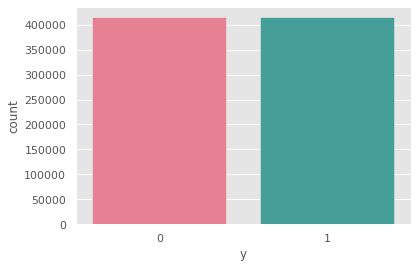

In [63]:
# As discussed at the start, we will use balanced data for all the 
# x_new and y_new we will use for balanced data set for all modules
randomsample=  RandomOverSampler()
x_new, y_new = randomsample.fit_resample(X, y)

from collections import Counter
print('Original dataset shape  {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_new)))
sns.countplot(y_new, palette='husl')
plt.show()

In [64]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)

## Logistic regression model with feature engineering and balance precidtor.

In [65]:
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_train.head()

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,0.00,0.16,0.16,0.34,0.20,0.30,0.33,0.18,0.11,0.10,0.20,0.00,1.00,0.13,0.93,1.00,0.01,0.16,0.00,0.67,0.52
190121,0.00,0.12,0.12,0.25,0.02,0.04,0.18,0.18,0.00,0.02,0.20,0.60,1.00,0.13,0.87,0.33,0.07,0.28,0.00,0.67,0.96
576417,0.14,0.28,0.27,0.34,0.20,0.30,0.33,0.18,0.31,0.27,0.20,0.00,1.00,0.13,0.71,0.67,0.57,0.13,0.17,0.00,0.26
86446,0.14,0.30,0.26,0.34,0.20,0.30,0.33,0.18,0.05,0.18,0.20,0.00,1.00,0.13,0.96,0.67,0.00,0.09,0.17,0.78,0.43
375294,0.00,0.11,0.11,0.34,0.20,0.30,0.33,0.18,0.17,0.16,0.20,0.00,1.00,0.13,0.64,1.00,0.07,0.09,0.17,0.00,0.26


In [66]:
X_train_sm = sm.add_constant(X_train)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580847
Model:                            GLM   Df Residuals:                   580825
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1026e+05
Date:                Thu, 16 Mar 2023   Deviance:                   6.2051e+05
Time:                        21:01:57   Pearson chi2:                 1.91e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2724
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3007      0.082    -64.434      0.000      -5.462      -5.139
banner_pos           0.2508      0.051      4.873      0.000       0.150       0.352
site_id              2.8042      0.080     35.185      0.000       2.648       2.960
site_domain          3.8857      0.088     44.233      0.000       3.714       4.058
site_category       -0.4715      0.050     -9.430      0.000      -0.570      -0.374
app_id               9.1385      0.086    105.650      0.000       8.969       9.308
app_domain          -2.5021      0.075    -33.396      0.000      -2.649      -2.355
app_category        -2.9293      0.068    -43.395      0.000      -3.062      -2.797
device_id            7.1608      0.184     38.928      0.000       6.800       7.521
device_ip            7.7517      0.038    204.344      0.000       7.677       7.826
device_model         3.3083      0.051     64.599      0.000       3.208       3.409
device_type          0.1755      0.041      4.278      0.000       0.095       0.256
device_conn_type     0.1967      0.025      7.859      0.000       0.148       0.246
C15                  0.8689      0.069     12.511      0.000       0.733       1.005
C16                 -0.3995      0.022    -18.301      0.000      -0.442      -0.357
C17                 -0.1991      0.015    -13.520      0.000      -0.228      -0.170
C18                 -0.0439      0.009     -4.835      0.000      -0.062      -0.026
C19                  0.2487      0.016     15.785      0.000       0.218       0.280
C21                 -0.1822      0.015    -12.326      0.000      -0.211      -0.153
dayofweek            0.0071      0.011      0.656      0.512      -0.014       0.028
day                 -0.0053      0.010     -0.543      0.587      -0.024       0.014
hour                -0.1265      0.012    -10.508      0.000      -0.150      -0.103
====================================================================================
"""

In [67]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[210642  79781]
 [ 81125 209299]]
0.7229804061999116


In [68]:
def sm_model_evaluation (model, x_test, y_test):
    '''
    model = sm model
    y_test = series of labels 
    columns = list of columns in features
    x_test = test dataframe 
    '''
    X_sm = sm.add_constant(x_test)
    y_pred = res.predict(X_sm)
    y_train_pred_final = pd.DataFrame({'y':y_test, 'y_Prob':y_pred})
    y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
    # Let's check the overall accuracy.
    print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))
    confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
    print(confusion)

In [69]:
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
sm_model_evaluation(res, X_test, y_test)  

0.7229919456886336
[[90203 34265]
 [34692 89775]]


In [70]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,602.46
3,site_domain,6.82
2,site_id,6.77
7,app_category,2.23
14,C16,2.08
6,app_domain,2.04
4,site_category,1.99
5,app_id,1.78
18,C21,1.76
16,C18,1.63


In [71]:
# VIF looks good, w.r.t P values hour and dayofweek have got highest, will remove and build the model.

X_train_sm.drop(['hour','day'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580847
Model:                            GLM   Df Residuals:                   580827
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1031e+05
Date:                Thu, 16 Mar 2023   Deviance:                   6.2062e+05
Time:                        21:02:12   Pearson chi2:                 1.88e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2723
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -5.3699      0.082    -65.516      0.000      -5.531      -5.209
banner_pos           0.2492      0.051      4.845      0.000       0.148       0.350
site_id              2.7895      0.080     35.033      0.000       2.633       2.946
site_domain          3.8821      0.088     44.222      0.000       3.710       4.054
site_category       -0.4685      0.050     -9.375      0.000      -0.566      -0.371
app_id               9.1094      0.086    105.448      0.000       8.940       9.279
app_domain          -2.4645      0.075    -32.965      0.000      -2.611      -2.318
app_category        -2.9316      0.067    -43.480      0.000      -3.064      -2.799
device_id            7.1601      0.184     38.914      0.000       6.800       7.521
device_ip            7.7528      0.038    204.415      0.000       7.679       7.827
device_model         3.3111      0.051     64.658      0.000       3.211       3.411
device_type          0.1602      0.041      3.909      0.000       0.080       0.241
device_conn_type     0.1958      0.025      7.827      0.000       0.147       0.245
C15                  0.8707      0.069     12.563      0.000       0.735       1.007
C16                 -0.3958      0.022    -18.142      0.000      -0.439      -0.353
C17                 -0.1968      0.014    -13.625      0.000      -0.225      -0.169
C18                 -0.0453      0.009     -4.996      0.000      -0.063      -0.028
C19                  0.2474      0.016     15.712      0.000       0.217       0.278
C21                 -0.1756      0.015    -11.891      0.000      -0.205      -0.147
dayofweek            0.0072      0.011      0.663      0.507      -0.014       0.028
====================================================================================
"""

In [72]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,596.80
3,site_domain,6.82
2,site_id,6.76
7,app_category,2.22
14,C16,2.08
6,app_domain,2.04
4,site_category,1.99
5,app_id,1.77
18,C21,1.76
16,C18,1.63


In [73]:
X_train_sm.drop(['dayofweek','device_ip', 'C15'], axis=1, inplace= True)
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               580847
Model:                            GLM   Df Residuals:                   580830
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.4249e+05
Date:                Thu, 16 Mar 2023   Deviance:                   6.8498e+05
Time:                        21:02:23   Pearson chi2:                 1.26e+06
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1870
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.0267      0.041    -98.807      0.000      -4.107      -3.947
banner_pos          -0.1697      0.049     -3.439      0.001      -0.266      -0.073
site_id              4.1220      0.077     53.846      0.000       3.972       4.272
site_domain          3.0595      0.084     36.528      0.000       2.895       3.224
site_category       -0.3249      0.047     -6.918      0.000      -0.417      -0.233
app_id              10.2211      0.084    121.536      0.000      10.056      10.386
app_domain          -1.9944      0.072    -27.882      0.000      -2.135      -1.854
app_category        -3.3786      0.064    -52.841      0.000      -3.504      -3.253
device_id            9.9509      0.184     54.169      0.000       9.591      10.311
device_model         4.3207      0.049     87.875      0.000       4.224       4.417
device_type          0.5652      0.039     14.472      0.000       0.489       0.642
device_conn_type     0.1205      0.024      5.109      0.000       0.074       0.167
C16                 -0.6659      0.020    -32.718      0.000      -0.706      -0.626
C17                 -0.1838      0.014    -13.408      0.000      -0.211      -0.157
C18                 -0.1035      0.009    -12.114      0.000      -0.120      -0.087
C19                  0.1760      0.015     11.868      0.000       0.147       0.205
C21                 -0.1994      0.014    -14.384      0.000      -0.227      -0.172
====================================================================================
"""

In [74]:
vif = pd.DataFrame()
vif['Features'] = X_train_sm.columns
vif['VIF'] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,82.86
3,site_domain,6.82
2,site_id,6.75
7,app_category,2.21
6,app_domain,2.03
4,site_category,1.98
12,C16,1.84
16,C21,1.75
5,app_id,1.75
14,C18,1.63


### Model P values and VIF looks good, will find the best threshold for classification.

In [75]:
y_train_pred = res.predict(X_train_sm)
y_train_pred_final = pd.DataFrame({'y':y_train, 'y_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.y_Prob.map(lambda x: 1 if x > 0.5 else 0)
confusion = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final.predicted )
print(confusion)
print(metrics.accuracy_score(y_train_pred_final.y, y_train_pred_final.predicted))

[[182870 107553]
 [ 75967 214457]]
0.684047606340396


In [76]:
col = list(X_train_sm.columns)
col.remove('const')
sm_model_evaluation(res, X_test[col], y_test)  

0.6828288509048547
[[78089 46379]
 [32576 91891]]


In [77]:
numbers = [float(x)/20 for x in range(20)]
print(numbers)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.y_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
319980,0,0.33,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
190121,0,0.12,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
576417,1,0.73,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0
86446,0,0.64,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
375294,0,0.32,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
cutoff_df = pd.DataFrame( columns = ['Thresold_prob','accuracy','recall','precision'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.y, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    TP = cm1[1,1] # true positive 
    TN = cm1[0,0] # true negatives
    FP = cm1[0,1] # false positives
    FN = cm1[1,0] # false negatives
    accuracy = (TP + TN)/total1
    
    recall = TP / (TP+FP)
    precision = TP / (TP+FN)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision]
cutoff_df

,Thresold_prob,accuracy,recall,precision
0.00,0.00,0.50,0.50,1.00
0.05,0.05,0.50,0.50,1.00
0.10,0.10,0.51,0.51,1.00
0.15,0.15,0.55,0.53,0.99
0.20,0.20,0.59,0.55,0.97
0.25,0.25,0.62,0.57,0.96
0.30,0.30,0.65,0.59,0.93
0.35,0.35,0.67,0.62,0.89
0.40,0.40,0.68,0.63,0.85
0.45,0.45,0.68,0.65,0.81


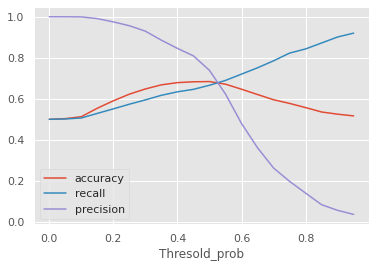

In [79]:
cutoff_df.plot.line(x='Thresold_prob', y=['accuracy','recall','precision'])
plt.show()

In [80]:
y_train_pred_final['final_predicted'] = y_train_pred_final.y_Prob.map( lambda x: 1 if x > 0.50 else 0)
y_train_pred_final.head()

,y,y_Prob,predicted,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,final_predicted
319980,0,0.33,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
190121,0,0.12,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
576417,1,0.73,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1
86446,0,0.64,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1
375294,0,0.32,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
X_train_sm.drop('const', axis= 1, inplace= True)
X_test = X_test[X_train_sm.columns]
print(X_train_sm.shape)
print(X_test.shape)

(580847, 16)
(248935, 16)


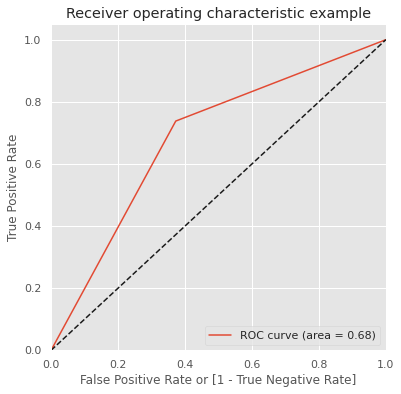

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
0,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.82,0.83,0.83,0.82,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,logistic reg with feature engine,0.68,0.66,0.74,0.68,0.66,0.74,0.68,0.69,0.68,0.68,0.68,0.68


In [82]:
model = LogisticRegression()
model.fit(X_train_sm, y_train)
accuracy, cnf_matrix = model_eval(model, X_test[X_train_sm.columns], y_test)
temp = store_results("logistic reg with feature engine", y_train, X_train_sm, y_test, X_test[X_train_sm.columns], \
                     model, 5)
draw_roc(model, X_test[X_train_sm.columns], y_test)
outcome = outcome.append(temp)
outcome


## Decision tree model with feature engineering and balance precidtor.


In [83]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,0,0.16,0.16,0.18,0.20,0.20,0.20,0.17,0.11,0.09,1,0,320,50,2566,3,47,42,0,27,12
190121,0,0.12,0.12,0.13,0.02,0.02,0.11,0.17,0.00,0.02,1,3,320,50,2424,1,161,71,0,27,22


In [84]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train, y_train)
feature_importances = dt_tree.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.26
9,device_model,0.18
20,hour,0.16
1,site_id,0.11
4,app_id,0.05
19,day,0.05
18,dayofweek,0.04
14,C17,0.04
2,site_domain,0.02
16,C19,0.02


In [85]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)

In [86]:
dt_tree = DecisionTreeClassifier(random_state=42)
dt_tree.fit(X_train[rf_cols], y_train)

DecisionTreeClassifier(random_state=42)

['site_id', 'site_domain', 'app_id', 'device_ip', 'device_model', 'C17', 'C19', 'dayofweek', 'day', 'hour']
10
Train results
accuracy 0.9717051133947494
cnf_matrix 
 [[278661  11762]
 [  4673 285751]]
Test results
accuracy 0.885106553919698
cnf_matrix 
 [[101249  23219]
 [  5382 119085]]


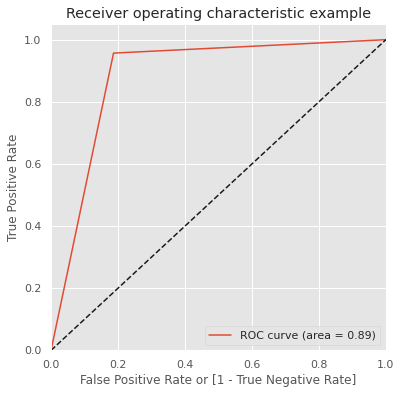

(array([0.        , 0.18654594, 1.        ]),
 array([0.        , 0.95675962, 1.        ]),
 array([2, 1, 0]))

In [87]:
print(rf_cols)
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]
print(len(rf_cols))
predict_rf = dt_tree.predict(X_train)
predict_rf_test = dt_tree.predict(X_test)

accuracy, cnf_matrix = model_eval(dt_tree, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n",cnf_matrix)

draw_roc(dt_tree, X_test, y_test)


 Above basic tree with right features seems data is overfitting. having the correct hyper parameter tuning help in interpretation and bit of over fitting of the model.

In [88]:
param_grid = {
    'max_depth': range(1,15),
    'min_samples_leaf': range(10,200,20),
    'min_samples_split': range(50, 150, 50)
    
}
n_folds = 5
dtree = DecisionTreeClassifier(random_state= 42)
tree3 = GridSearchCV(dtree, param_grid, cv=n_folds, n_jobs =-1,return_train_score=True)
tree3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(10, 200, 20),
                         'min_samples_split': range(50, 150, 50)},
             return_train_score=True)

In [89]:
tree3.best_params_

{'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 50}

In [90]:
tree3.best_estimator_

DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)

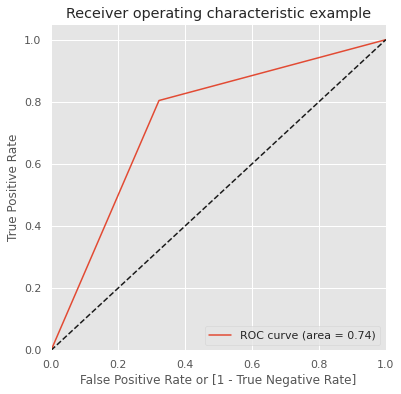

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
0,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
0,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
0,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
0,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88
0,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.82,0.83,0.83,0.82,0.83
0,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
0,logistic reg with feature engine,0.68,0.66,0.74,0.68,0.66,0.74,0.68,0.69,0.68,0.68,0.68,0.68
0,Decision tree with feature engine,0.74,0.71,0.80,0.74,0.71,0.80,0.74,0.74,0.74,0.74,0.74,0.74


In [91]:
dt_tree =  DecisionTreeClassifier(max_depth=14, min_samples_leaf=10, min_samples_split=50,
                       random_state=42)
dt_tree.fit(X_train, y_train)
accuracy, cnf_matrix = model_eval(dt_tree, X_test, y_test)
temp = store_results("Decision tree with feature engine", y_train, X_train, y_test, X_test, \
                     dt_tree, 5)
draw_roc(dt_tree, X_test, y_test)
outcome = outcome.append(temp)
outcome

## Random forest model with feature engineering and balance precidtor.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, stratify= y_new, test_size= 0.3, random_state= 42)
X_train.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
319980,0,0.16,0.16,0.18,0.20,0.20,0.20,0.17,0.11,0.09,1,0,320,50,2566,3,47,42,0,27,12
190121,0,0.12,0.12,0.13,0.02,0.02,0.11,0.17,0.00,0.02,1,3,320,50,2424,1,161,71,0,27,22


In [93]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
feature_importances = model_rf.feature_importances_
features = X_train.columns
df = pd.DataFrame({'features': features, 'importance': feature_importances})
df.sort_values(by='importance', ascending = False)

,features,importance
8,device_ip,0.24
9,device_model,0.22
20,hour,0.16
1,site_id,0.07
2,site_domain,0.06
4,app_id,0.05
19,day,0.04
18,dayofweek,0.03
14,C17,0.03
17,C21,0.02


using random forest feature importance metric to decide on best features and building the model.

['site_id', 'site_domain', 'app_id', 'device_ip', 'device_model', 'C17', 'dayofweek', 'day', 'hour']
9


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Train results
accuracy 0.9716224754539492
cnf_matrix 
 [[277723  12700]
 [  3783 286641]]
Test results
accuracy 0.8960853234780164
cnf_matrix 
 [[103143  21325]
 [  4543 119924]]


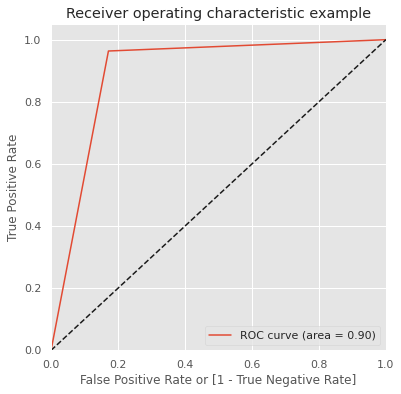

(array([0.        , 0.17132918, 1.        ]),
 array([0.        , 0.96350037, 1.        ]),
 array([2, 1, 0]))

In [94]:
df = df[df.importance > 0.02]
rf_cols = []
for col in list(X_train.columns):
    if col in list(df.features):
        rf_cols.append(col)
        
X_train = X_train[rf_cols]
X_test = X_test[rf_cols]

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
print(rf_cols)

print(len(rf_cols))
predict_rf = model_rf.predict(X_train)
predict_rf_test = model_rf.predict(X_test)

accuracy, cnf_matrix = model_eval(model_rf, X_train, y_train)
print("Train results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

accuracy, cnf_matrix = model_eval(model_rf, X_test, y_test)
print("Test results")
print("accuracy",accuracy)
print("cnf_matrix \n", cnf_matrix)

draw_roc(model_rf, X_test, y_test)


In [95]:
temp = store_results("Random Forest with feature engine", y_train, X_train, y_test, X_test, \
                     model_rf, 5)
outcome = outcome.append(temp)

In [96]:
outcome.reset_index(drop=True, inplace=True)
outcome

,Model,Accuracy_train,recall_train,precision_train,Accuracy_test,recall_test,precision_test,CrossVal_Mean,CrossVal1,CrossVal2,CrossVal3,CrossVal4,CrossVal5
0,Dummy classifier,0.83,NaN,0.00,0.83,NaN,0.00,0.83,0.83,0.83,0.83,0.83,0.83
1,logistic regres - imbalance predict,0.84,0.62,0.22,0.84,0.62,0.22,0.84,0.84,0.84,0.84,0.85,0.85
2,logistic regres - balance predict,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72,0.72
3,decision tree basic - imbalance predict,0.78,0.35,0.35,0.78,0.35,0.35,0.78,0.78,0.78,0.78,0.77,0.78
4,decision tree basic - balance predict,0.90,0.84,0.97,0.90,0.84,0.97,0.88,0.88,0.88,0.88,0.88,0.88
5,Random forest basic - imbalance predict,0.82,0.47,0.27,0.82,0.47,0.27,0.83,0.82,0.83,0.83,0.82,0.83
6,Random forest basic - balance predict,0.91,0.86,0.97,0.91,0.86,0.97,0.89,0.89,0.89,0.89,0.89,0.89
7,logistic reg with feature engine,0.68,0.66,0.74,0.68,0.66,0.74,0.68,0.69,0.68,0.68,0.68,0.68
8,Decision tree with feature engine,0.74,0.71,0.80,0.74,0.71,0.80,0.74,0.74,0.74,0.74,0.74,0.74
9,Random Forest with feature engine,0.90,0.85,0.96,0.90,0.85,0.96,0.88,0.88,0.88,0.88,0.88,0.88


# conclusion
 If we have to select one model, Random forest classifier with feature enginnering looks promising and best. although after the feature engineering the training and test results looks same as before feature engineering, but model is very robust with new features and rightly fitted for both training and test dataset. 
 Decisiontree  and logistic regression classifer seems to have low accuracy, precision, and recall, overall random forest classifier seems doing better with all aspects.


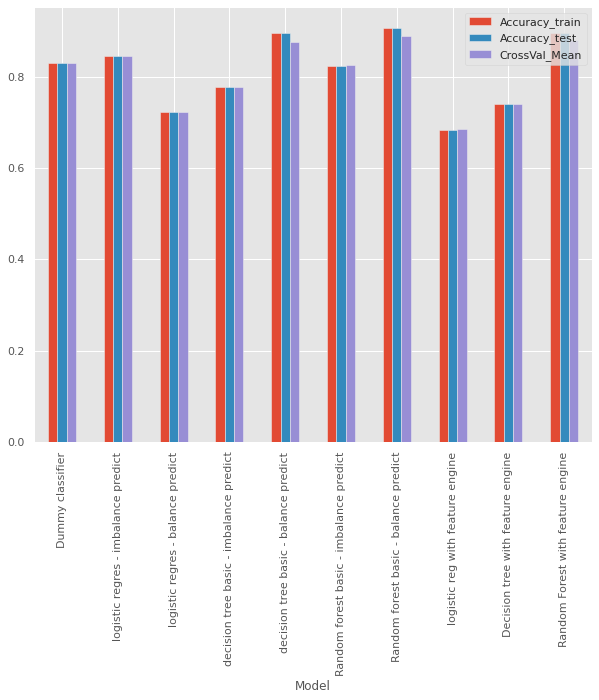

In [97]:
plt.rcParams["figure.figsize"] = (10,8)
outcome.plot(x='Model', y=['Accuracy_train','Accuracy_test','CrossVal_Mean'], kind="bar")
plt.xticks(rotation=90)
plt.show()

# Preparing test data for sumbission

In [98]:
test = pd.read_csv('../input/avazu-ctr-prediction/test.gz', parse_dates=['hour'], date_parser=parse_date)
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51


In [99]:
test['month'] = test['hour'].dt.month
test['dayofweek'] = test['hour'].dt.dayofweek
test['day'] = test['hour'].dt.day
test['hour_time'] = test['hour'].dt.hour
test.head(2)

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,month,dayofweek,day,hour_time
0,10000174058809264128.00,2014-10-31,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,69f45779,0eb711ec,1,0,8330,320,50,761,3,175,100075,23,10,4,31,0
1,10000182526920855552.00,2014-10-31,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8d44657,ecb851b2,1,0,22676,320,50,2616,0,35,100083,51,10,4,31,0


In [100]:
col = ['C15', 'C16', 'C19', 'C21']
for col in col:
    percentiles = test[col].quantile(0.98)
    if test[col].quantile(0.98) < 0.5 * test[col].max():
        test[col][test[col] >= percentiles] = percentiles


In [101]:
'''
test.drop(['month', 'C20'], axis=1, inplace=True)
labelEncoder= LabelEncoder()
for col in (test.columns):
    if test[col].dtype == "object":
        test[col] = labelEncoder.fit_transform(test[col])

test.head(2)
'''

'\ntest.drop([\'month\', \'C20\'], axis=1, inplace=True)\nlabelEncoder= LabelEncoder()\nfor col in (test.columns):\n    if test[col].dtype == "object":\n        test[col] = labelEncoder.fit_transform(test[col])\n\ntest.head(2)\n'

In [102]:
test.drop(['id', 'hour'], axis = 1, inplace = True) 
test.rename(columns={'hour_time': 'hour'},
          inplace=True, errors='raise')
test.columns

Index(['C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model',
       'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18',
       'C19', 'C20', 'C21', 'month', 'dayofweek', 'day', 'hour'],
      dtype='object')

In [103]:
test.drop(['month', 'C20'], axis=1, inplace=True)
test.drop(['C14', 'C1'], axis=1, inplace= True)

In [104]:
'''
for col in (test.columns):
    print(col)
    if test[col].dtype == "object":
        test[col] = target_encoder.transform(test)

test.head(2)
'''

'\nfor col in (test.columns):\n    print(col)\n    if test[col].dtype == "object":\n        test[col] = target_encoder.transform(test)\n\ntest.head(2)\n'

In [105]:
test =  target_encoder.transform(test)
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0,0.11,0.11,0.18,0.20,0.20,0.20,0.17,0.17,0.19,1,0,320,50,761,3,175,23,4,31,0
1,0,0.21,0.21,0.21,0.20,0.20,0.20,0.17,0.18,0.18,1,0,320,50,2616,0,35,51,4,31,0


In [106]:
test[test.columns]  = scaler.transform(test[test.columns])
test.head(2)

,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C15,C16,C17,C18,C19,C21,dayofweek,day,hour
0,0.00,0.11,0.11,0.34,0.20,0.30,0.33,0.18,0.17,0.20,0.20,0.00,1.00,0.13,0.25,1.00,0.08,0.09,0.67,1.11,0.00
1,0.00,0.21,0.21,0.40,0.20,0.30,0.33,0.18,0.18,0.19,0.20,0.00,1.00,0.13,0.95,0.00,0.00,0.20,0.67,1.11,0.00


In [107]:
# random forest with balanced data was our best model, hence using the same for submission.
rf_cols

['site_id',
 'site_domain',
 'app_id',
 'device_ip',
 'device_model',
 'C17',
 'dayofweek',
 'day',
 'hour']

In [108]:
test = test[rf_cols]
predict_sub = model_rf.predict(test)
print(len(predict_sub))
print(print(len(submission)))
print(predict_sub)

4577464
4577464
None
[0 0 0 ... 1 0 0]


In [109]:
submission['click'] = predict_sub
submission.head(2)

,id,click
0,10000174058809263569,0
1,10000182526920855428,0


In [110]:
submission.to_csv('submission.csv', index = False)

********************************************************** END **********************************************************